## Realistic Fall Detection in Real-World Streaming Scenarios with Costream

### Set things up

In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split

# --- Costream Imports ---
from costream.data import make_csv_loader, group_files_by_subject
from costream.evaluation import run_subject_cv, ModelSpec, critical_difference
from costream.model import CostClassifierCV
from costream.evaluation.visualization import metric_box, window_bar

# Directories
RES_DIR = Path("results"); RES_DIR.mkdir(exist_ok=True)
FIG_DIR = Path("figs"); FIG_DIR.mkdir(exist_ok=True)
DATA_DIR = Path("data/falls")
FREQ = 100  # Hz

# Define Feature Extraction (Magnitude)
def calc_mag(df):
    raw_mag = np.sqrt(df['acc_x']**2 + df['acc_y']**2 + df['acc_z']**2)
    return raw_mag / 9.81  # Normalize by gravity

loader = make_csv_loader(
    feature_cols=['mag'], 
    label_col='label',
    new_features={'mag': calc_mag}
)

WINDOW_SIZES = [3, 5, 7, 10, 15, 30, 60]
CV_FOLDS = 5
FREQ = 100

### Group Files and Load

In [2]:
# Returns: { 'subject_id': [path_to_csv, ...] }
# first define id extraction function if needed
# by default, the part of the filename before the
# first '-' or "_" is used as subject ID, or the
# entire filename if neither is found.
# in this case, we assume filenames like:
# F_00002186-01-2013-11-15-13-50-18.csv, where the
# id is the part after "F_": "00002186"
def id_extractor(p: str) -> str:
	name = os.path.splitext(os.path.basename(p))[0]
	s = name.split('-')[0].split('_')[1]
	return s
subject_map_paths = group_files_by_subject(
     DATA_DIR, id_extractor=id_extractor)

# We limit to subjects with sensor at L5
data_desc = pd.read_excel(
     "data/description.xlsx", engine='openpyxl',
     usecols=['Randomnumber', 'Sensor_location', 'Sample_rate_Hz']
)
l5 = data_desc[data_desc['Sensor_location'] == 'L5']
l5 = l5[l5['Sample_rate_Hz'] == FREQ]
l5_subjects = set(l5['Randomnumber'].str.split('-').str[0])
# Append subject missing from description file
l5_subjects.add('04404010')
subject_map_paths = {k: v for k, v in subject_map_paths.items() if k in l5_subjects}

all_subject_data = {}
for subj_id, paths in subject_map_paths.items():
    all_subject_data[subj_id] = loader(paths)

# Train/Test Split (Subject-wise)
all_subjects = list(all_subject_data.keys())
split_file = RES_DIR / "subjects.json"
if split_file.exists():
    with open(split_file, 'r') as f:
        splits = json.load(f)
        TRAIN_SUBJ = splits['train']
        TEST_SUBJ = splits['test']
    print(f"Loaded existing subject split: {len(TRAIN_SUBJ)} train, {len(TEST_SUBJ)} test.")
else:
    TRAIN_SUBJ, TEST_SUBJ = train_test_split(all_subjects, test_size=0.2, random_state=42)
    with open(split_file, 'w') as f:
        json.dump({"train": TRAIN_SUBJ, "test": TEST_SUBJ}, f)
    print(f"Created new subject split: {len(TRAIN_SUBJ)} train, {len(TEST_SUBJ)} test.")

# Filter data map for Training CV
train_data_map = {s: all_subject_data[s] for s in TRAIN_SUBJ if s in all_subject_data}

Loaded existing subject split: 32 train, 9 test.


### Load Models

In [29]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import ExtraTreesClassifier
from aeon.classification.convolution_based import MiniRocketClassifier
from aeon.classification.feature_based import Catch22Classifier
from aeon.classification.interval_based import QUANTClassifier
from aeon.classification.deep_learning import ResNetClassifier
from piping import PipingClassifier as Piping
from sklearn.dummy import DummyClassifier

from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="loss", patience=20, min_delta=1e-4, restore_best_weights=True
)


def get_models(kind="real"):
    specs = []
    if kind == "baseline":
        # Dummy Baseline
        specs.append(
            ModelSpec("DummyADL", DummyClassifier(strategy="constant", constant=0))
        )
    else:
        specs.append(
            ModelSpec(
                "ExtraTrees",
                estimator=make_pipeline(
                    StandardScaler(),
                    SimpleImputer(strategy="mean", missing_values=np.nan),
                    ExtraTreesClassifier(
                        n_estimators=150,
                        max_features=0.1,
                        criterion="entropy",
                        random_state=42,
                    ),
                ),
            )
        )
        specs.append(
            ModelSpec(
                name="MiniRocket",
                estimator=make_pipeline(
                    StandardScaler(),
                    SimpleImputer(strategy="mean", missing_values=np.nan),
                    MiniRocketClassifier(n_jobs=-1, random_state=42),
                ),
            )
        )
        specs.append(
            ModelSpec(
                name="QUANT",
                estimator=make_pipeline(
                    StandardScaler(),
                    SimpleImputer(strategy="mean", missing_values=np.nan),
                    QUANTClassifier(random_state=42),
                ),
            )
        )
        specs.append(
            ModelSpec(
                name="Piping",
                estimator=make_pipeline(
                    SimpleImputer(strategy="mean", missing_values=np.nan),
                    Piping(scales=[3, 5, 10, 20, 30, 60])
                ),
            )
        )
        specs.append(
            ModelSpec(
                name="Catch22",
                estimator=make_pipeline(
                    StandardScaler(),
                    SimpleImputer(strategy="mean", missing_values=np.nan),
                    Catch22Classifier(),
                ),
            )
        )
    return specs

### Cross-Validation with Window Size Grid

In [4]:
# Baseline CV
# dummy_results = []
# for win in WINDOW_SIZES:
#     print(f"Running Dummy CV for window {win}s...")
#     res = run_subject_cv(
#         subject_map=train_data_map,
#         model_specs=get_models("baseline"),
#         feature_cols=['mag'],
#         window_size=float(win),
#         cv=CV_FOLDS,
#         step=1.0,          # Step size for negatives
#         spacing="multiphase", # <--- YOUR LOGIC IS HERE
#         verbose=False
#     )
#     res['window_size'] = win
#     dummy_results.append(res)

# dummy_df = pd.concat(dummy_results, ignore_index=True)
# dummy_df.to_csv(RES_DIR / "dummy_cv_results.csv")

In [30]:
# Real Models CV
real_results = []
for win in WINDOW_SIZES:
    print(f"Running CV for window {win}s...")
    res = run_subject_cv(
        subject_map=train_data_map,
        model_specs=get_models("real"),
        feature_cols=['mag'],
        window_size=float(win),
        cv=CV_FOLDS,
        step=1.0,
        spacing="multiphase",
        verbose=True,
        use_post_event_data=False, 
    )
    res['window_size'] = win
    real_results.append(res)
real_df = pd.concat(real_results, ignore_index=True)
real_df.to_csv(RES_DIR / "real_cv_results.csv")

Running CV for window 3s...

=== Fold 1/5 | Train Subjects: 25 | Test Subjects: 7 ===
  Segmented Train Data: (2519, 300)
  Fold Results (Mean F1):
model
Catch22       0.810811
ExtraTrees    0.857143
MiniRocket    0.871795
Piping        0.744186
QUANT         0.829268
Name: f1-score, dtype: float64

=== Fold 2/5 | Train Subjects: 25 | Test Subjects: 7 ===
  Segmented Train Data: (1805, 300)
  Fold Results (Mean F1):
model
Catch22       0.760000
ExtraTrees    0.851064
MiniRocket    0.851852
Piping        0.808511
QUANT         0.816327
Name: f1-score, dtype: float64

=== Fold 3/5 | Train Subjects: 26 | Test Subjects: 6 ===
  Segmented Train Data: (2540, 300)
  Fold Results (Mean F1):
model
Catch22       0.666667
ExtraTrees    0.476190
MiniRocket    0.769231
Piping        0.866667
QUANT         0.814815
Name: f1-score, dtype: float64

=== Fold 4/5 | Train Subjects: 26 | Test Subjects: 6 ===
  Segmented Train Data: (2510, 300)
  Fold Results (Mean F1):
model
Catch22       0.763636
ExtraTr

In [31]:
real_df

,model,tp,fp,tn,fn,runtime,delay,precision,recall,specificity,f1-score,auc,false alarm rate,miss rate,gain,thresh,fold,window_size
0,ExtraTrees,15,1,22003,4,0.042007,-0.789474,0.937500,0.789474,0.999955,0.857143,0.894714,0.016304,0.065217,-0.146738,0.5,1,3
1,MiniRocket,17,3,22001,2,0.086534,-1.736842,0.850000,0.894737,0.999864,0.871795,0.947300,0.048913,0.032608,-0.114129,0.5,1,3
2,QUANT,17,5,21999,2,0.318971,-0.947368,0.772727,0.894737,0.999773,0.829268,0.947255,0.081521,0.032608,-0.146738,0.5,1,3
3,Piping,16,8,21996,3,6.069722,-2.210526,0.666667,0.842105,0.999636,0.744186,0.920871,0.130434,0.048913,-0.228259,0.5,1,3
4,Catch22,15,3,22001,4,0.359321,-2.789474,0.833333,0.789474,0.999864,0.810811,0.894669,0.048913,0.065217,-0.179346,0.5,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,ExtraTrees,31,3,45584,15,0.175523,-2.639405,0.911765,0.673913,0.999934,0.775000,0.836924,0.022427,0.112136,-0.246699,0.5,5,60
171,MiniRocket,40,83,45504,6,5.768287,-7.986333,0.325203,0.869565,0.998179,0.473373,0.933872,0.620484,0.044854,-0.710193,0.5,5,60
172,QUANT,31,7,45580,15,7.773940,2.495429,0.815789,0.673913,0.999846,0.738095,0.836880,0.052330,0.112136,-0.276601,0.5,5,60
173,Piping,25,8,45579,21,42.556925,3.719524,0.757576,0.543478,0.999825,0.632911,0.771651,0.059806,0.156990,-0.373786,0.5,5,60


### Analysis and Plots

Best Window Sizes: {'Catch22': 7, 'ExtraTrees': 60, 'MiniRocket': 3, 'Piping': 3, 'QUANT': 7}


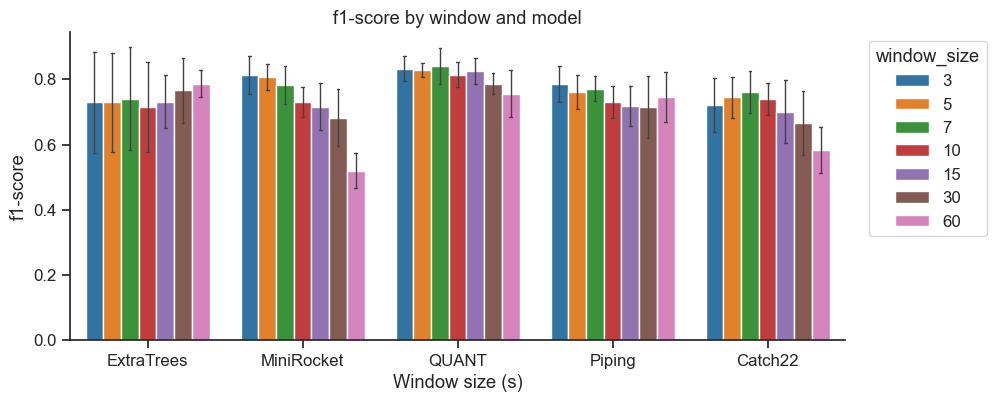

<Figure size 1000x600 with 0 Axes>

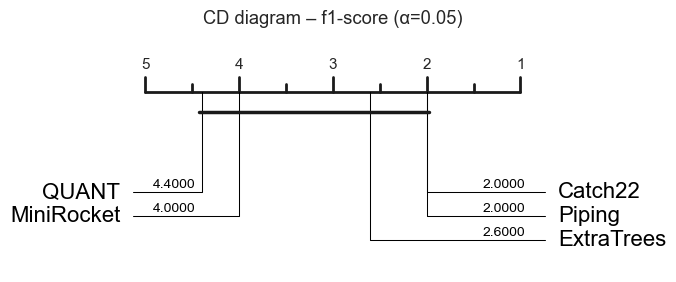

In [32]:
# Find Best Window Size (based on F1)
real_df = pd.read_csv(RES_DIR / "real_cv_results.csv")
best_rows = (
    real_df.groupby(["model", "window_size"])["f1-score"]
    .mean()
    .unstack("window_size")
    .idxmax(axis=1)
)
print("Best Window Sizes:", best_rows.to_dict())

# Bar Plot by Window Size
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
window_bar(real_df, metric="f1-score", x="model", hue="window_size", errorbar="sd")
plt.show()

# Critical Difference Diagram (Requires aeon)
# # Ensure the dataframe has a 'fold' column (run_subject_cv adds this automatically)
try:
    critical_difference(real_df, metric="f1-score")
except ImportError:
    print("Install 'aeon' to see Critical Difference diagram.")

### Cost Sensitive Threshold Tuning

In [6]:
%load_ext autoreload
%autoreload 2

from costream.segmentation import create_training_data
from costream.evaluation import run_experiment
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from costream.model import CostClassifierCV
from costream.data import extract_streaming_data
from aeon.classification.interval_based import QUANTClassifier

w = 10.0  # Best window size from previous step
fn_cost_factor = 2.0  # alpha

# Flatten the list of DFs for all training subjects
train_dfs_flat = []
for s in TRAIN_SUBJ:
    if s in all_subject_data:
        train_dfs_flat.extend(all_subject_data[s])

print(f"Generating Training Data (Window={w}s)...")
X_train, y_train = create_training_data(
    train_dfs_flat,
    feature_cols=['mag'],
    window_size=w,
    spacing="multiphase",
    freq=100,
    signal_thresh=1.4
)
print(f"Train Shape: {X_train.shape}, Class Balance: {np.bincount(y_train)}")

# --- Prepare Test Data (Continuous Streams) ---
print("Preparing Test Data...")

test_signals, test_events = extract_streaming_data(
    subject_map=all_subject_data,
    subjects=TEST_SUBJ,
    feature_col='mag',
    label_col='label'
)

print(f"Test Set: {len(test_signals)} recordings with {len(test_events)} events.")

base_model = make_pipeline(
    StandardScaler(),
    SimpleImputer(strategy="mean", missing_values=np.nan),
    QUANTClassifier(random_state=0),
)

tuned_model = CostClassifierCV(
    base_estimators=[
        make_pipeline(
            StandardScaler(),
            SimpleImputer(strategy="mean", missing_values=np.nan),
            QUANTClassifier(random_state=0),
        )
    ],
    method="stacking",
    alpha=2,
    random_state=0
)

specs = [ModelSpec("QUANT Untuned", base_model), ModelSpec("QUANT Alpha2", tuned_model)]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Generating Training Data (Window=10.0s)...
Train Shape: (5859, 1000), Class Balance: [5724  135]
Preparing Test Data...
Test Set: 21 recordings with 21 events.


In [6]:
print("Running Threshold Tuning Experiment...")
results_df = run_experiment(
    X_train, y_train,
    test_signals=test_signals,
    test_event_points=test_events,
    model_specs=specs,
    window_size=w,
    step=1.0,
    freq=100,
    tolerance=20,
    signal_thresh=1.4,
    verbose=True
)

print("\nResults:")
display(results_df)

results_df.to_csv(RES_DIR / "threshold_tuning_results.csv", index=False)

Running Threshold Tuning Experiment...
TRAINING 2 models...

TESTING on 21 recordings...
  Evaluating QUANT Untuned... Done.
  Evaluating QUANT Alpha2... Done.

Results:


,model,tp,fp,tn,fn,runtime,delay,precision,recall,specificity,f1-score,auc,false alarm rate,miss rate,gain,thresh
0,QUANT Untuned,17,1,24838,4,0.748901,-1.106667,0.944444,0.809524,0.999960,0.871795,0.904742,0.014359,0.057437,-0.129233,0.500000
1,QUANT Alpha2,18,2,24837,3,0.743243,-1.773333,0.900000,0.857143,0.999919,0.878049,0.928531,0.028718,0.043078,-0.114873,0.282828


### Visualise a specific trace

In [ ]:
from costream.segmentation import sliding_window_inference
from costream.evaluation import evaluate_recording, plot_confidence

tm = specs[1].estimator.fit(X_train, y_train) 
thresh = getattr(tm, "threshold_", 0.5)

In [14]:
tm.threshold_

0.17171717171717174

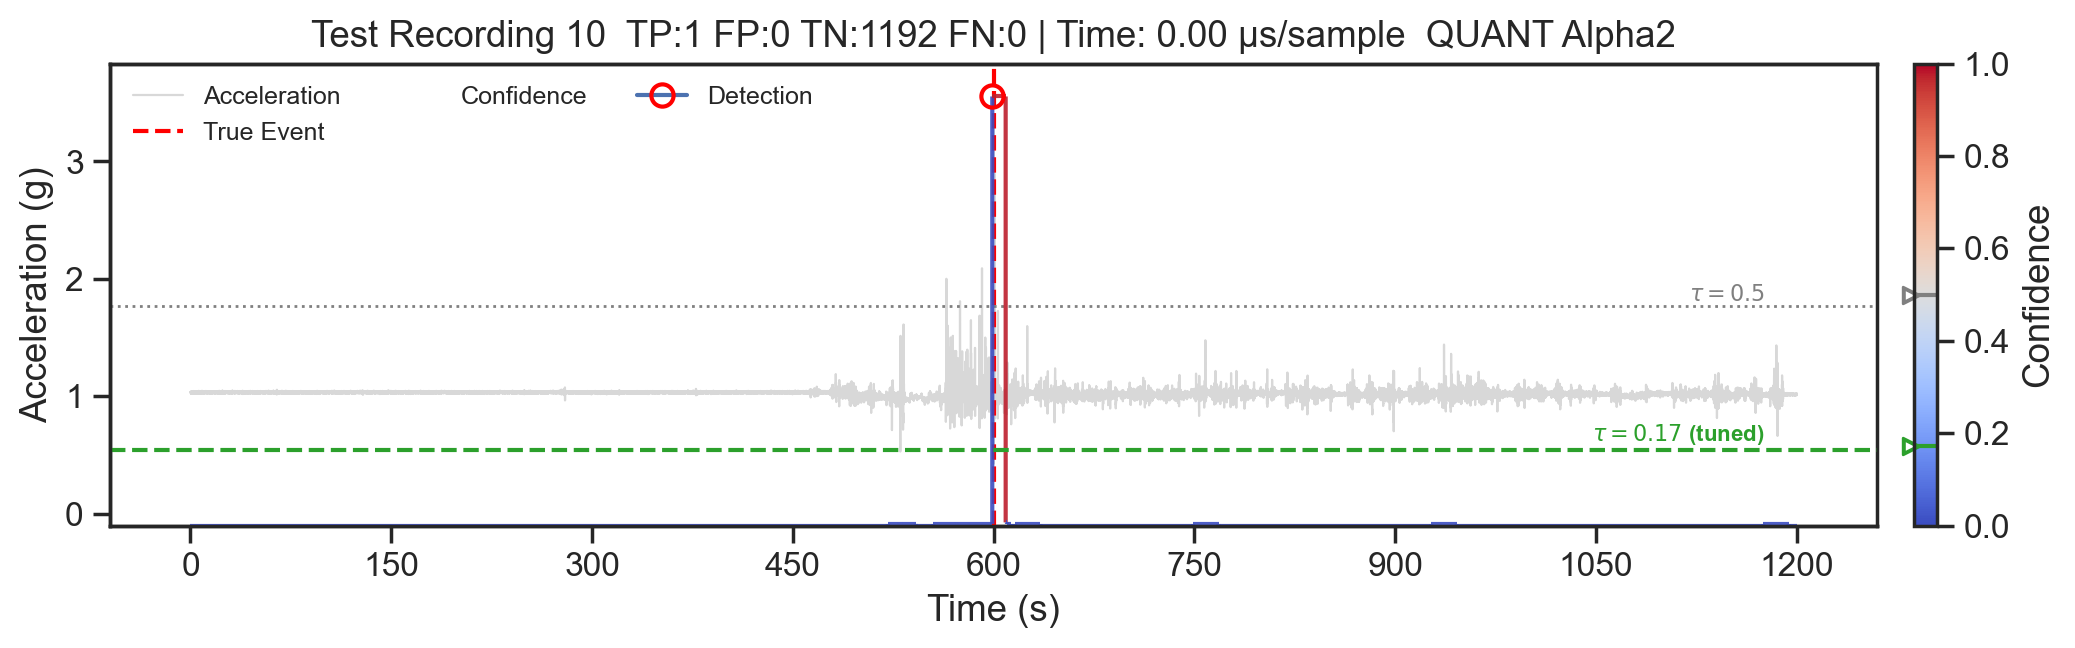

In [17]:
# Select a specific test recording (e.g., first one)
test_idx = 10
signal = test_signals[test_idx]
event_points = test_events[test_idx]

# Perform Sliding Window Inference
conf_map, runtime = sliding_window_inference(
    signal, model=tm, window_size=w, step=1.0, freq=100, signal_thresh=1.4
)

# Calculate stats for the title
cm, highs, _ = evaluate_recording(
    len(signal), event_points, conf_map, confidence_thresh=thresh, tolerance=20
)
tn, fp, fn, tp = cm.ravel()

plot_confidence(
    signal,
    conf_map,
    event_points,
    tp, fp, tn, fn,
    high_conf=highs,
    model_name="QUANT Alpha2",
    thresh_line=thresh,
    freq=100,
    title=f"Test Recording {test_idx}",
)

In [7]:
results_df = pd.read_csv(RES_DIR / "threshold_tuning_results.csv")
results_df

,model,tp,fp,tn,fn,runtime,delay,precision,recall,specificity,f1-score,auc,false alarm rate,miss rate,gain,thresh
0,QUANT Untuned,17,1,24838,4,0.748901,-1.106667,0.944444,0.809524,0.999960,0.871795,0.904742,0.014359,0.057437,-0.129233,0.500000
1,QUANT Alpha2,18,2,24837,3,0.743243,-1.773333,0.900000,0.857143,0.999919,0.878049,0.928531,0.028718,0.043078,-0.114873,0.282828


In [18]:
cm_tuned

array([[24837,     2],
       [    3,    18]])

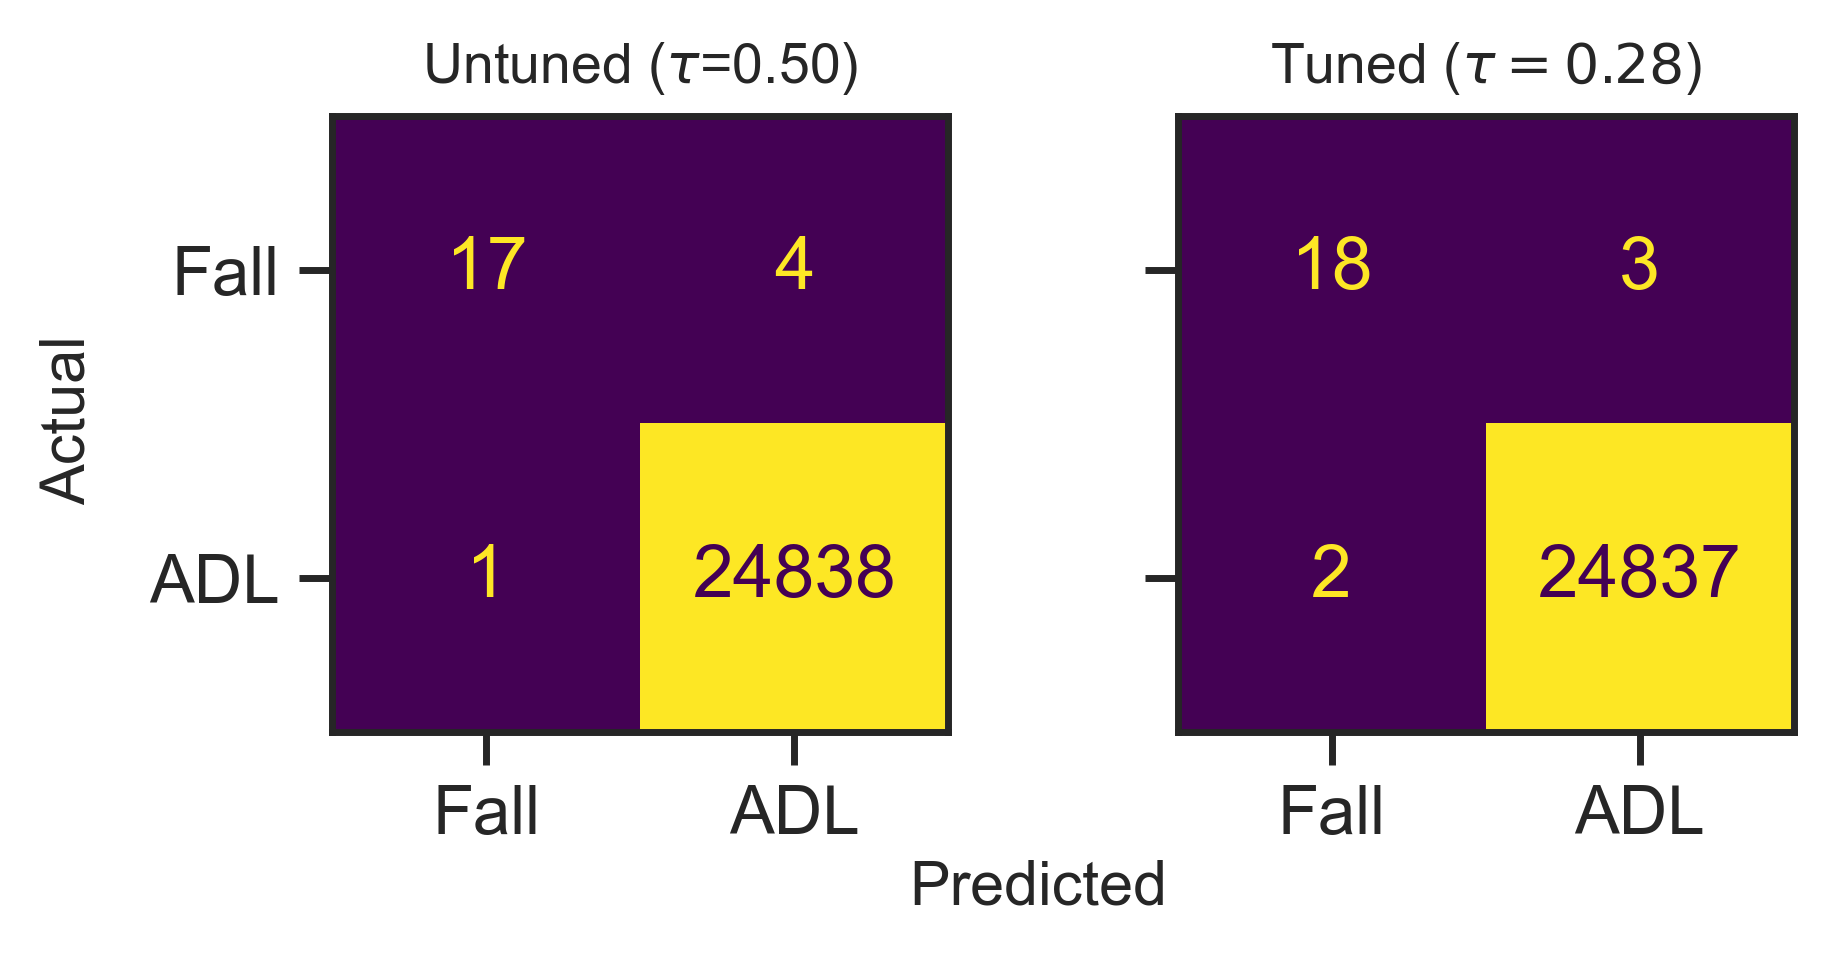

In [20]:
from costream.evaluation.visualization import plot_cm_comparison

cm_df = results_df[['model', 'tp', 'fp', 'tn', 'fn']]
cm_untuned = cm_df[cm_df['model'] == 'QUANT Untuned'][['tn', 'fp', 'fn', 'tp']].values[0]
cm_tuned = cm_df[cm_df['model'] == 'QUANT Alpha2'][['tn', 'fp', 'fn', 'tp']].values[0]
cm_untuned = cm_untuned.reshape(2,2)
cm_tuned = cm_tuned.reshape(2,2)
cm_untuned, cm_tuned

plot_cm_comparison(
    cm_untuned, 
    cm_tuned, 
    labels=["Fall", "ADL"],
    title_tuned=f"Tuned ($\\tau={0.282828:.2f}$)",
    save_path=FIG_DIR / "cm_comparison.pdf"
)

In [ ]:
quant_thresh_df = pd.read_csv(RES_DIR / "quant_thresh_metrics_19August.csv")
quant_thresh_df

,model,seed,window_size,runtime,delay,precision,recall,specificity,f1-score,auc,false alarm rate,miss rate,gain,thresh,fn_factor
0,QUANT,0,10,4.461270,-1.582857,0.863636,0.904762,0.999879,0.883721,0.952321,0.430776,0.287184,-0.000019,0.50000,2
1,QUANT,0,10,4.607384,-3.630476,0.840000,1.000000,0.999839,0.913043,0.999920,0.574367,0.000000,-0.000011,0.40404,2
